## Install other dependencies

In [ ]:
# !pip install -q jupyter_bbox_widget supervision ultralytics open3d matplotlib

### Import the necessary libraries

In [1]:
import torch
import tkinter as tk
from tkinter import filedialog
from IPython.display import display
from tools.utils import display_masked_areas
import open3d as o3d
from tools.orthograohic_image import capture_textured_image_and_depth_from_obj
from tools.extract_and_save_masked_areas import extract_and_save_masked_areas
from tools.generate_topographic_map import generate_topographic_map
from tools.plot_depth_profile_for_mesh import plot_depth_profile_for_mesh
from tools.project_masks_to_3d import project_masks_to_mesh

from open3d.cuda.pybind.geometry import TriangleMesh
import cv2
import numpy as np

from ultralytics import SAM
import matplotlib.pyplot as plt
import ipywidgets as widgets
from jupyter_bbox_widget import BBoxWidget

from numpy import ndarray
from typing import Union
import base64

# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
MODEL_TYPE = "vit_h"


def load_mesh(filename):
    """ Load a mesh from an OBJ file and return its vertices and normals. """
    mesh: TriangleMesh = o3d.io.read_triangle_mesh(filename)
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)  # Assume normals are already normalized
    return vertices, normals


# helper function that loads an image before adding it to the widget
def encode_image(input: Union[str,ndarray]):
    if isinstance(input, str):     
        with open(input, "rb") as image:
            image_bytes = image.read()
    else:
        image_bytes = cv2.imencode('.jpg', input)[1]
        
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# Function to open file dialog and get the file path
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("OBJ files", "*.obj")])
    path_widget.value = file_path

# Create a button widget
button_widget = widgets.Button(description="Select .obj file")

# Create a text widget to display the file path
path_widget = widgets.Text(
    value='',
    placeholder='File path will appear here',
    description='File Path:',
    disabled=False
)
# Bind the function to the button click event
button_widget.on_click(lambda b: select_file())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Load Segment Anything Model 2 (SAM2) with the specified weights
model = SAM("sam2_l.pt")

# Display model information (optional)
model.info()

Model summary: 854 layers, 224,430,130 parameters, 224,430,130 gradients


(854, 224430130, 224430130, 0.0)

## Select the .obj file to segment

In [3]:
# Display the widgets
display(button_widget)
display(path_widget)

Button(description='Select .obj file', style=ButtonStyle())

Text(value='', description='File Path:', placeholder='File path will appear here')

## Capture Textured Orthographic Image and Depth Map

Set the zoom level (default is 0.50), and the number of iterations (default is 1) for Mesh filtering, and use_sharpen (default is True) to use sharpening filter, otherwise False will use smoothing filter

In [4]:
obj_path = path_widget.value
image_path, output_depth_path, camera_params_path = capture_textured_image_and_depth_from_obj(obj_path,zoom=0.40,number_of_iterations=1,use_sharpen=False,strength=0.1)

### Display Orthographic Image

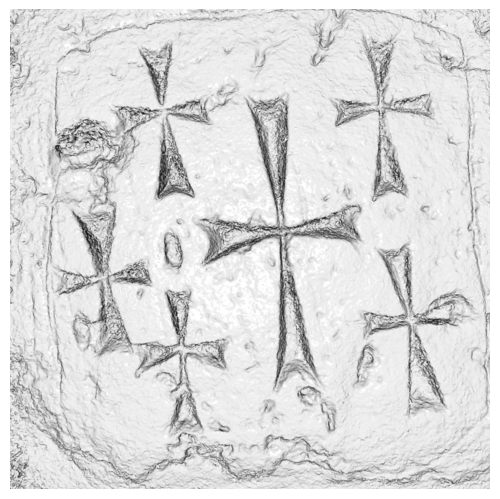

In [5]:
# Load the orthographic image
ortho_image = cv2.imread(image_path,cv2.IMREAD_COLOR)

# Display the orthographic image
plt.imshow(ortho_image)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

### Draw Box

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [6]:
# Create a BBoxWidget
widget = BBoxWidget( classes=['cross'])
widget.image = encode_image(image_path)

# Set resolution of the image
widget.width = ortho_image.shape[1]
widget.height = ortho_image.shape[0]

# Display the widget
widget
### Get Bounding Boxes

BBoxWidget(classes=['cross'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

In [7]:
# Get the bounding boxes
boxes = []
for box in widget.bboxes:
    boxes.append(np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']]))
    
# Print the box coordinates
boxes

[array([224,  69, 433, 410]),
 array([683,  52, 909, 413]),
 array([751, 507, 954, 876]),
 array([402, 178, 755, 814]),
 array([ 89, 422, 305, 739]),
 array([256, 597, 475, 904])]

### Generate masks using SAM2 model

In [8]:
# Generate masks using SAM2
all_masks = model(image_path, bboxes=boxes)

/homes/kfirs/.conda/envs/msc_project_env/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


/homes/kfirs/.conda/envs/msc_project_env/lib/python3.10/site-packages/ultralytics/models/sam/predict.py:693: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  bboxes = torch.as_tensor(bboxes, dtype=torch.float32, device=self.device)


image 1/1 /mobileye/RPT/users/kfirs/kfir_project/MSC_Project/images/S01_ortho.png: 1024x1024 4227.9ms
Speed: 16.5ms preprocess, 4227.9ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)


### Display the masks

In [9]:
for mask in all_masks:
    mask.show()

### Save the masks and mask colors

In [10]:
# Generate random mask colors
mask_colors = np.random.randint(100, 255, (len(all_masks[0]), 3))

# Convert the masks to numpy arrays
all_masks = all_masks[0].masks.data.cpu().numpy()

# Save the masks and mask colors the same folder as the image with a prefix
masks_path = image_path.replace(".png", "_masks.npy")
colors_path = image_path.replace(".png", "_colors.npy")
np.save(masks_path, all_masks)
np.save(colors_path, mask_colors)

# Display the paths to the saved masks and colors
masks_path, colors_path

('./images/S01_ortho_masks.npy', './images/S01_ortho_colors.npy')

### Project the masks to the 3D mesh

In [11]:
# Apply the masks to the mesh
masked_point_cloud = project_masks_to_mesh(obj_path, masks_path, colors_path, camera_params_path, output_depth_path)

Processing non-masked areas: 100%|██████████| 903908/903908 [00:13<00:00, 65935.99it/s]
Assigning colors to mesh vertices: 689698it [00:08, 80927.85it/s]


### Extract and save the masked areas as a 3D mesh separately

In [12]:
from pathlib import Path

output_dir =Path('datasets') 
label = Path(obj_path).stem
### Extract the 3D masked mesh from the masked point cloud
masks_folders_list:list = extract_and_save_masked_areas(masked_point_cloud, output_dir,label)

Saved masked area 0 with color [    0.51765         0.4     0.58039] to datasets/S01_mask_0/mask.ply
Saved masked area 1 with color [    0.59608     0.47059     0.88627] to datasets/S01_mask_1/mask.ply
Saved masked area 2 with color [    0.70196     0.88627      0.8902] to datasets/S01_mask_2/mask.ply
Saved masked area 3 with color [    0.83529     0.44314     0.66275] to datasets/S01_mask_3/mask.ply
Saved masked area 4 with color [    0.92157     0.41961     0.68627] to datasets/S01_mask_4/mask.ply
Saved masked area 5 with color [    0.99608      0.6902     0.40784] to datasets/S01_mask_5/mask.ply
Finished extracting and saving all masked areas.


### Display the masked areas

In [13]:
for masked_area_folder in masks_folders_list:
    display_masked_areas(masked_area_folder)

Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.


### Generate the topographic map (contour of the masked areas)

In [14]:
for masked_area_folder in masks_folders_list:
    topographic_map_path = generate_topographic_map(masked_area_folder, num_contours=1, num_iterations=4)

### Generate the depth profile for the meshed areas

In [15]:
for masked_area_folder in masks_folders_list:
    plot_depth_profile_for_mesh(masked_area_folder)


KeyboardInterrupt



Error in callback <function flush_figures at 0x7ffe5142cca0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 